# Using the MaterialSolvated

In the [first tutorial](../fitting/simple_fitting.rst), we looked at a straight forward example of a polymer film at the solid/liquid interface. 
To analyse this data, we constructed a model with two layers, one SiO<sub>2</sub> and one of the polymer film, and when the analysis was performed, the scattering length density of the polymer film was allowed to vary to find an optimum value. 
However, it is likely that this scattering length density is in fact a compound value arising from the mixture of the polymer with some D<sub>2</sub>O intercalated. 
Therefore, if, for example, the surface covereage of the polymer was known, it may be possible to determine the scattering length density alone. 
Of course, this could be calculated from the optimal scattering length density for the film, but it is more intuitive to include this in our modelling approach. 
Here, we will show how to use the `MaterialSolvated` [type](../../sample/material_library.rst#materialsolvated) to perform this analysis. 

First configure matplotlib to place figures in notebook and import needed modules

In [1]:
%matplotlib inline

import numpy as np
import scipp as sc
import pooch
import refnx

import easyreflectometry

from easyreflectometry.data import load
from easyreflectometry.sample import Layer
from easyreflectometry.sample import Sample
from easyreflectometry.sample import Material
from easyreflectometry.sample import MaterialSolvated
from easyreflectometry.sample import Multilayer
from easyreflectometry.model import Model
from easyreflectometry.model import PercentageFhwm
from easyreflectometry.calculators import CalculatorFactory
from easyreflectometry.fitting import Fitter
from easyreflectometry.plot import plot

Showing the version of specific softare for reproducibility

In [2]:
print(f'numpy: {np.__version__}')
print(f'scipp: {sc.__version__}')
print(f'easyreflectometry: {easyreflectometry.__version__}')
print(f'refnx: {refnx.__version__}')

numpy: 1.26.0
scipp: 24.9.1
easyreflectometry: 1.1.1
refnx: 0.1.48


For information about the data being read in and the details of the model see [the previous tutorial](../fitting/simple_fitting.rst). 
We will gloss over these details here.
We use `pooch` to fetch the file from the repository.

In [3]:
file_path = pooch.retrieve(
    # URL to one of Pooch's test files
    url="https://raw.githubusercontent.com/EasyScience/EasyReflectometryLib/master/docs/src/tutorials/fitting/example.ort",
    known_hash="82d0c95c069092279a799a8131ad3710335f601d9f1080754b387f42e407dfab",
)
data = load(file_path)

## Constructing the model

Previously the model consisted of four materials, we will construct those again here. 

In [4]:
si = Material(sld=2.07, isld=0, name='Si')
sio2 = Material(sld=3.47, isld=0, name='SiO2')
film = Material(sld=2.0, isld=0, name='Film')
d2o = Material(sld=6.36, isld=0, name='D2O')

However, now we will construct a component object (for type `MaterialSolvated`), based on the knowledge that there is a 75 % surface coverage of the silicon block by the polymer film.
Note that this object takes the material (polymer film) and a solvent, which both are instances of `Material`. The fraction of material and solvent is given by the `solvent_fraction`, which in this case is 25% solvent.

In [5]:
solvated_film_material = MaterialSolvated(
    material=film,
    solvent=d2o,
    solvent_fraction=0.25,
    name='Solvated Film'
)

So for the `solvated_film` object, the scattering length density is calculated as,

$$ \rho_{\mathrm{solv film}} = (1-\phi)\rho_{\mathrm{film}} + \phi\rho_{\mathrm{D}_2\mathrm{O}}, $$

where the scattering length densities are given with $\rho$ and the coverage with $\phi$. 
This means that when we investigate the `solvated_film` object, the scattering length density will be 3.09e-6 Å<sup>-2</sup>

In [6]:
solvated_film_material

Solvated Film:
  solvent_fraction: 0.250 dimensionless
  sld: 3.090e-6 1/Å^2
  isld: 0.000e-6 1/Å^2
  material:
    Film:
      sld: 2.000e-6 1/Å^2
      isld: 0.000e-6 1/Å^2
  solvent:
    D2O:
      sld: 6.360e-6 1/Å^2
      isld: 0.000e-6 1/Å^2

Now, we can construct our layers, sample and model. 

In [7]:
si_layer = Layer(material=si, thickness=0, roughness=0, name='Si layer')
sio2_layer = Layer(material=sio2, thickness=30, roughness=3, name='SiO2 layer')
superphase = Multilayer([si_layer, sio2_layer], name='Si/SiO2 Superphase')

solvated_film = Multilayer(Layer(material=solvated_film_material, thickness=250, roughness=3, name='Film Layer'))

subphase = Multilayer(Layer(material=d2o, thickness=0, roughness=3, name='D2O Subphase'))

resolution_function = PercentageFhwm(0.02)
sample = Sample(superphase, solvated_film, subphase, name='Film Structure')
model = Model(
    sample=sample,
    scale=1,
    background=1e-6,
    resolution_function=resolution_function,
    name='Film Model'
)

## Setting varying parameters

Previously, the scattering length density of the `film_layer` was allowed to vary (in addition to other parameters). 
This time, the scattering length density will for the `film` be varied, leading to a change in the `solvated_film_layer` scattering length density. 
We show this in the four code cells below. 

In [8]:
film.sld.value = 2.0

In [9]:
print(solvated_film.layers[0].material.sld)

3.09


In [10]:
film.sld.value = 2.5

In [11]:
print(solvated_film.layers[0].material.sld)

3.465


The parameter bounds are then set as follows. 

In [12]:
# Thicknesses
sio2_layer.thickness.bounds = (15, 50)
solvated_film.layers[0].thickness.bounds = (200, 300)
# Roughnesses
sio2_layer.roughness.bounds = (1, 15)
solvated_film.layers[0].roughness.bounds = (1, 15)
subphase.layers[0].roughness.bounds = (1, 15)
# Scattering length density
film.sld.bounds = (0.1, 3)
# Background
model.background.bounds = (1e-8, 1e-5)
# Scale
model.scale.bounds = (0.5, 1.5)

## Perform the fitting

Having constructed the model and set the relevant varying parameters, we run the analysis (using the default [refnx engine](https://refnx.readthedocs.io/)). 

In [13]:
interface = CalculatorFactory()
model.interface = interface
fitter = Fitter(model)
analysed = fitter.fit(data)

The model fits well to the data.

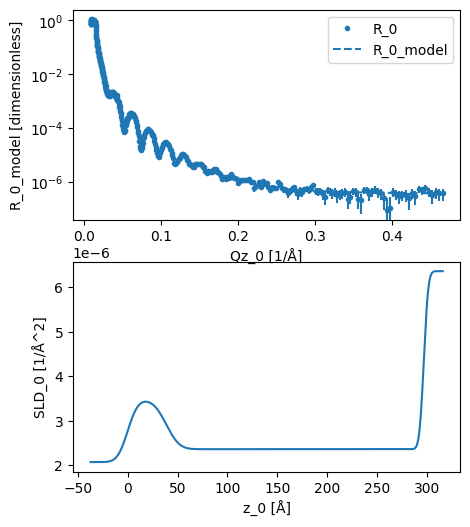

In [14]:
plot(analysed)

We can probe the `MaterialSolvated` object to investigate the scattering length density of the polymer film alone.

In [15]:
solvated_film_material

Solvated Film:
  solvent_fraction: 0.250 dimensionless
  sld: 2.360e-6 1/Å^2
  isld: 0.000e-6 1/Å^2
  material:
    Film:
      sld: 1.027e-6 1/Å^2
      isld: 0.000e-6 1/Å^2
  solvent:
    D2O:
      sld: 6.360e-6 1/Å^2
      isld: 0.000e-6 1/Å^2

The fit reproducing the measured reflectivity curve yields that the scattering length density (SLD) of the layer is 2.36E-6 Å<sup>-2</sup>.  Remember this layer is composed of 75% of the polymer film layer (SLD of 1.026E-6 Å<sup>-2</sup> fitted) and 25% of D2O (SLD of 6.36E-6  Å<sup>-2</sup> known) making (0.75 * 1.026 + 0.25 * 6.36)E-6 = 2.36E-6 Å<sup>-2</sup>.  This is the same as the result from the [previous tutorial](../fitting/simple_fitting.rst).